In [1]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

#keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten , Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Visualization**

In [3]:
#Directories for training and testing data
train_dir = '/content/drive/MyDrive/MRI Images/Training'
test_dir = '/content/drive/MyDrive/MRI Images/Testing'

#load and shuffle the train data
train_paths = []
train_labels = []

#Load and shuffle the training data
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

#load and shuffle the testing data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [4]:
import matplotlib.pyplot as plt

#select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)
random_indices


[371, 1108, 4125, 4264, 1180, 2545, 1528, 4723, 4244, 4833]

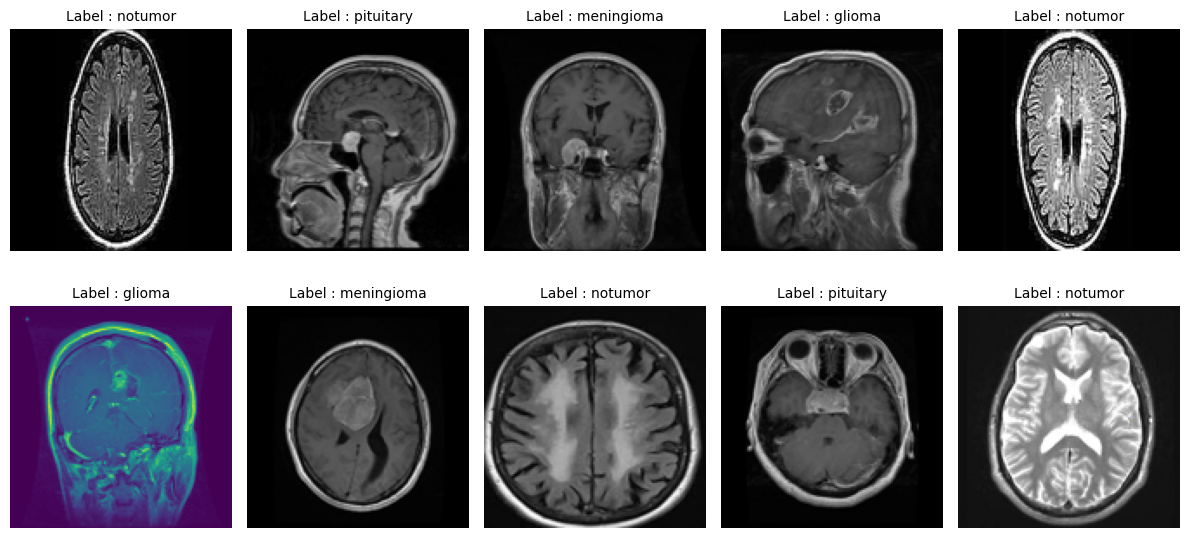

In [5]:
#create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

#Loop through the random indices and display images
for i , idx in enumerate(random_indices):
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((128, 128))

  #Display images
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f"Label : {train_labels[idx]}", fontsize = 10)

plt.tight_layout()
plt.show()



# **Image Preprocessing** (Helper function)

In [6]:
# Image Augmentation Function
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image)/255.0
  return image

# Load images and apply augmentation
def open_images(paths):
  images = []
  for path in paths:
    img = load_img(path, target_size = (IMG_SIZE, IMG_SIZE))
    img = augment_image(img)
    images.append(img)
  return np.array(images)

#Encoder labels (Convert label names to integers)
def encode_label(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels] # this will turn the labels into 0, 1, 2, 3 numbers
  return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size= 12, epochs = 1):
  for _ in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i: i + batch_size]
      batch_images = open_images(batch_paths) # opan and augment images
      batch_labels = labels[i: i+ batch_size]
      batch_labels = encode_label(batch_labels) # encoded labels
      yield batch_images, batch_labels

# **Model**

# WE ARE USING VGG16 FOR TRANSFER LEARNING

The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.


*   First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 128x128 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

*  Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

*  Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

*  After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

*  Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

*   Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

*  After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

*  Next, another Dropout layer is added with model.add(Dropout(0.2))

*  Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.










In [7]:
# Model Architecture
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

IMG_SIZE = 128
base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers except the last few
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-4:]:
    layer.trainable = True

# Functional API
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(len(os.listdir(train_dir)), activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

# Hyper parameters
batch_size = 20
steps = int(len(train_paths)/ batch_size) # how many batches per epoch
epochs = 5

# train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 2146s 8s/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7551
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - loss: 0.2615 - sparse_categorical_accuracy: 0.9039
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.1857 - sparse_categorical_accuracy: 0.9289
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.1199 - sparse_categorical_accuracy: 0.9538
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - loss: 0.0857 - sparse_categorical_accuracy: 0.9686


# **Train and Val Props**

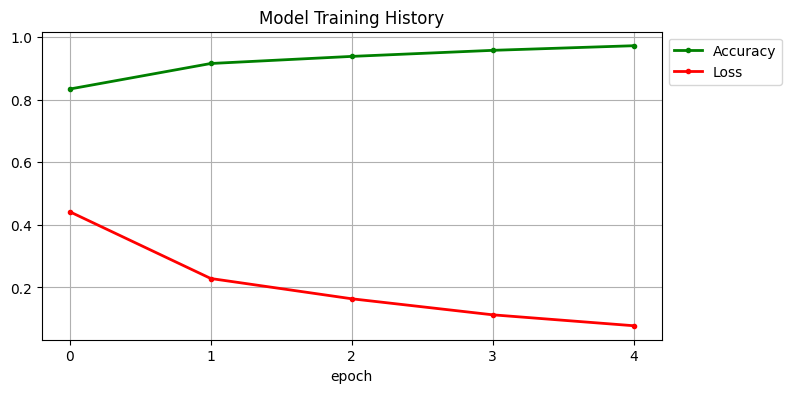

In [8]:
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth = 2)
plt.plot(history.history['loss'], '.r-', linewidth = 2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# **Model Classification Report**

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Prediction on test data
test_images = open_images(test_paths)
test_label_encoded = encode_label(test_labels)

# Predict using the trained model
test_predictions = model.predict(test_images)

# Classification Report
print("Classification Report: ")
print(classification_report(test_label_encoded, np.argmax(test_predictions, axis = 1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       306
           1       0.98      0.98      0.98       300
           2       0.98      1.00      0.99       405
           3       0.98      0.88      0.92       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



# **Model Confusion Plot**

Confusion Matrix
[[291   5   5   5]
 [  3 294   2   1]
 [  1   0 404   0]
 [ 36   1   0 263]]


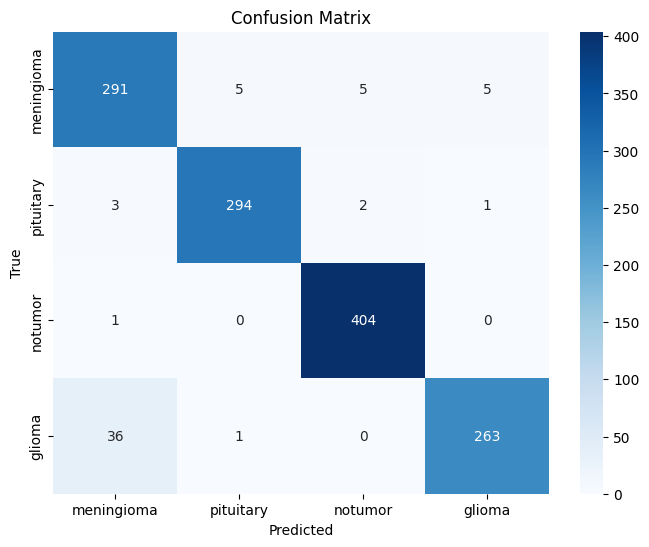

In [10]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_label_encoded, np.argmax(test_predictions, axis = 1))
print("Confusion Matrix")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **Roc Curve Plot**

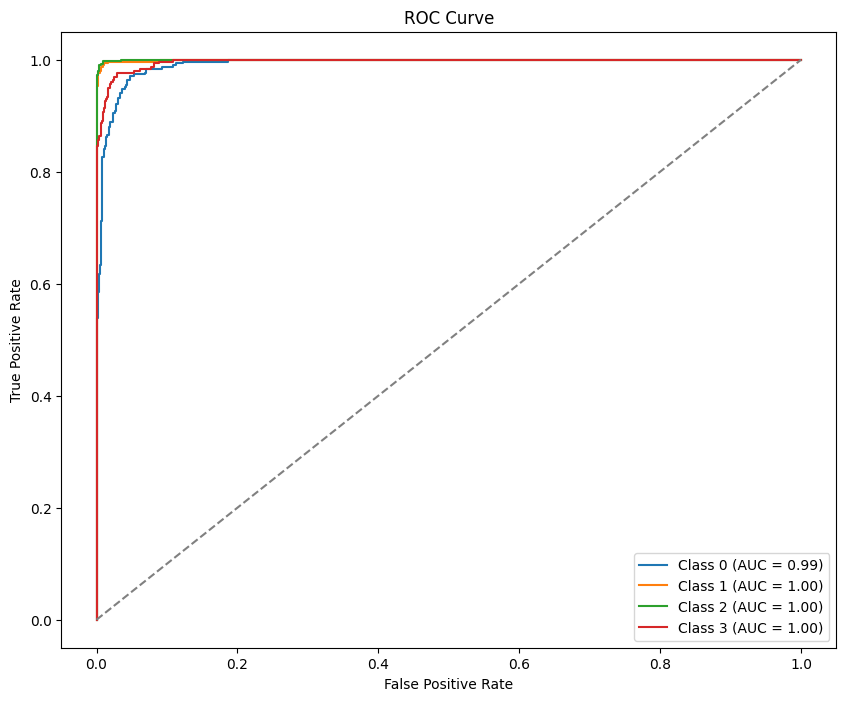

In [11]:
#ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_label_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# **Save and Load Model**

In [12]:
# Save the entire model
model.save('model.keras')

In [14]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.keras')


# **MRI Tumour Detection System**

In [15]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['meningioma', 'pituitary', 'notumor', 'glioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


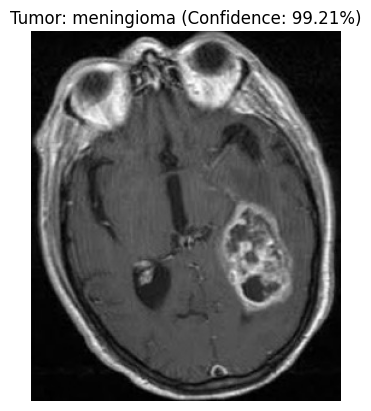

In [16]:
# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0001.jpg'   # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


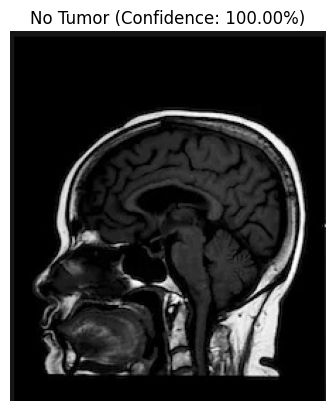

In [17]:
# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


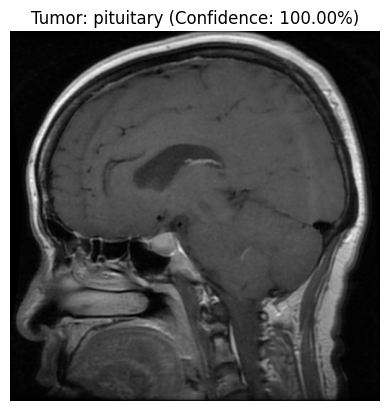

In [18]:
# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-piTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


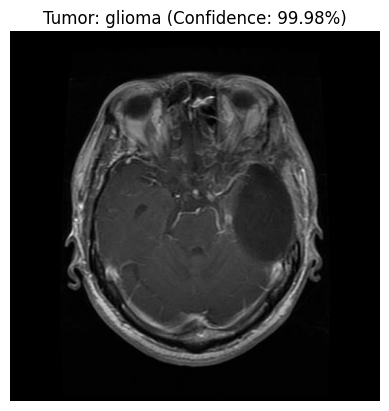

In [19]:
# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)